# 1. 数据加载

In [20]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torch


## 1.1 定义图像转换

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6953, 0.6752, 0.6424], std=[0.0941, 0.0914, 0.0880])
])


## 1.2 读取数据集并添加标签

In [22]:
data_dir = './archive'
dataset = ImageFolder(data_dir, transform=transform)

## 1.3 划分数据集

In [23]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"数据集总大小: {total_size}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(test_dataset)}")

# 打印类别信息
print("类别映射:", dataset.class_to_idx)

数据集总大小: 40000
训练集大小: 32000
验证集大小: 8000
类别映射: {'Negative': 0, 'Positive': 1}


## 1.4 创建 DataLoader

In [24]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. 测试 DataLoader
def test_dataloader(dataloader, dataset_name):
    print(f"\n测试 {dataset_name} DataLoader:")
    for batch_idx, (images, labels) in enumerate(dataloader):
        print(f"Batch {batch_idx + 1}:")
        print(f"  图像张量形状: {images.shape}")
        print(f"  标签张量形状: {labels.shape}")
        print(f"  标签值: {labels.tolist()}")
        
        # 只打印第一个批次的信息
        if batch_idx == 0:
            break

# 测试训练集和验证集的 DataLoader
test_dataloader(train_loader, "训练集")
test_dataloader(test_loader, "验证集")


测试 训练集 DataLoader:
Batch 1:
  图像张量形状: torch.Size([128, 3, 224, 224])
  标签张量形状: torch.Size([128])
  标签值: [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]

测试 验证集 DataLoader:
Batch 1:
  图像张量形状: torch.Size([128, 3, 224, 224])
  标签张量形状: torch.Size([128])
  标签值: [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1]


# 2 搭建网络

## 2.1 常规CNN搭建网络

In [26]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # 输入通道3，输出通道16，卷积核大小3x3，padding（填充）大小, 输出224x224x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 *28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))     # 224x224x3  --> (conv1)224x224x16 --> (pool1)112x112x16
        x = self.pool(self.relu(self.conv2(x)))     # 112x112x16 --> (conv2)112x112x32 --> (pool2) 56x56x32
        x = self.pool(self.relu(self.conv3(x)))     #  56x56x32  --> (conv3) 56x56x64  --> (pool3) 28x28x64
        x = x.view(-1, 64 * 28 * 28)                #  28x28x64  --> (view)  50176
        x = self.relu(self.fc1(x))                  #    50176   --> (fc1)    512
        x = self.fc2(x)                             #     512    --> (fc2)     2
        return x

In [28]:
# 检查是否有可用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN().to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# 定义优化器
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [ ]:
num_epochs = 10
train_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

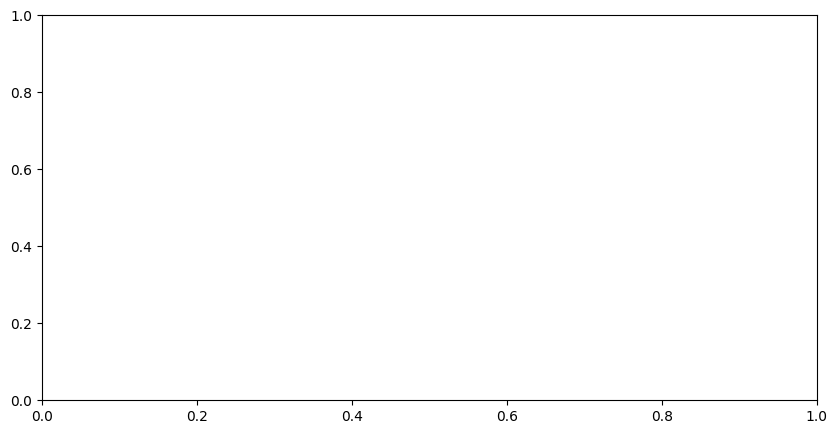

In [30]:
# 可视化
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [34]:
# 模型评估
import torchmetrics
from torchmetrics.classification import *
def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    
    accuracy_metric = BinaryAccuracy().to(device)
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_score_metric = BinaryF1Score().to(device)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)    # 转为标签
            
            accuracy_metric.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_score_metric.update(preds, labels)

    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    f1_score = f1_score_metric.compute()

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}')

evaluate_model(model, test_loader, device)

Accuracy: 0.9942
Precision: 0.9987
Recall: 0.9897
F1 Score: 0.9942
